<a href="https://colab.research.google.com/github/Romira915/jds_compe/blob/main/compe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
  !pip install mecab-python3 transformers fugashi ipadic torch_optimizer nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import copy
import time
import random
import re
import unicodedata

import nltk
from nltk.corpus import wordnet
import MeCab
import numpy as np
import pandas as pd
import torch
import transformers
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score
from torch import Tensor, cuda, optim
from torch.nn import functional as F
import torch_optimizer
from torch.utils.data import DataLoader, Dataset
from torch.cuda.amp import autocast, GradScaler
import math
from torch.autograd.function import InplaceFunction
from torch.nn import Parameter
import torch.nn.init as init
from transformers import (AutoModel, AutoTokenizer, BertJapaneseTokenizer,
                          BertModel, BartForSequenceClassification, BertConfig, DistilBertConfig, DistilBertTokenizer, DistilBertModel, AlbertConfig, AlbertModel, AlbertForMaskedLM, AlbertTokenizerFast)

In [ ]:
nltk.download("popular")

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package movie_reviews is already up-to-date!
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Package names is already up-to-date!
[nltk_data]    | Do

True

In [ ]:
train_path = "train.csv"
test_path = "test.csv"
compe_path = "compe.csv"
submission_path = "submission.csv"
custom_train_path = "training.1600000.processed.noemoticon-ja-fixed.csv"

try:
  from google.colab import drive
  drive.mount('/content/drive')

  compe_dir = "/content/drive/My Drive/Documents/compe/"

  train_path = compe_dir + train_path
  test_path = compe_dir + test_path
  compe_path = compe_dir + compe_path
  submission_path = compe_dir + submission_path
  custom_train_path = compe_dir + custom_train_path

except ImportError:
  pass

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
SEED = 223819057

In [ ]:
custom_train_df = pd.read_csv(custom_train_path)
custom_train_df = custom_train_df[["text", "target"]].rename(columns={"target": "label"})
custom_train_df.loc[custom_train_df["label"] == 0, "label"] = 1
custom_train_df.loc[custom_train_df["label"] == 4, "label"] = 0
print(custom_train_df["label"].value_counts())

0    24091
1    11301
Name: label, dtype: int64


In [ ]:
custom_train_df_0 = custom_train_df.query("label == 0")
custom_train_df_1 = custom_train_df.query("label == 1")
drop_size = len(custom_train_df_0) - len(custom_train_df_1)
custom_train_df_0, _ = train_test_split(custom_train_df_0, test_size=drop_size, shuffle=True, random_state=SEED)
print(len(custom_train_df_0))

custom_train_df = pd.concat([custom_train_df_0, custom_train_df_1], axis=0)
print(len(custom_train_df))

11301
22602


In [ ]:
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)
compe_df = pd.read_csv(compe_path)

train_df, valid_df = train_test_split(
    train_df, test_size=0.2, shuffle=True, random_state=SEED)

# train_df = pd.concat([train_df, test_df], axis=0)
# train_df = pd.concat([train_df, custom_train_df], axis=0)

train_text = train_df["text"].values.astype('U')
valid_text = valid_df["text"].values.astype('U')
test_text = test_df["text"].values.astype('U')
y = train_df["label"].values.astype("int8")
valid_y = valid_df["label"].values.astype("int8")
test_y = test_df["label"].values.astype("int8")
compe_text = compe_df["text"].values.astype('U')

# model_name = "nlptown/bert-base-multilingual-uncased-sentiment"
# model_name = "daigo/bert-base-japanese-sentiment"
model_name = "cl-tohoku/bert-base-japanese-whole-word-masking"
# model_name = "ken11/albert-base-japanese-v1"

In [ ]:
MARK = []
# MARK = ["、", "。", "，", "．", "\n"]
def clean_text(text):
    replaced_text = text
    for m in MARK:
      replaced_text = replaced_text.replace(m, ' ')
    # replaced_text = re.sub(r'[【】]', ' ', replaced_text)       # 【】の除去
    # replaced_text = re.sub(r'[（）()]', ' ', replaced_text)     # （）の除去
    # replaced_text = re.sub(r'[［］\[\]]', ' ', replaced_text)   # ［］の除去
    replaced_text = re.sub(r'[@＠]\w+', '', replaced_text)  # メンションの除去
    replaced_text = re.sub(
        r'https?:\/\/.*?[\r\n ]', '', replaced_text)  # URLの除去
    replaced_text = re.sub(r'　', ' ', replaced_text)  # 全角空白の除去
    return replaced_text

def clean_url(html_text):
    cleaned_text = re.sub(r'http\S+', '', html_text)
    return cleaned_text

In [ ]:
def normalize(text):
    normalized_text = normalize_unicode(text)
    normalized_text = normalize_number(normalized_text)
    normalized_text = lower_text(normalized_text)
    return normalized_text
    
def lower_text(text):
    return text.lower()

def normalize_unicode(text, form='NFKC'):
    normalized_text = unicodedata.normalize(form, text)
    return normalized_text

def normalize_number(text):
    replaced_text = re.sub(r'\d+', '0', text)
    return replaced_text
    
def lemmatize_term(term, pos=None):
    if pos is None:
        synsets = wordnet.synsets(term)
        if not synsets:
            return term
        pos = synsets[0].pos()
        if pos == wordnet.ADJ_SAT:
            pos = wordnet.ADJ
    return nltk.WordNetLemmatizer().lemmatize(term, pos=pos)

In [ ]:
# 前処理
def mark_remove(text: str):
  text = clean_text(text)
  # text = clean_url(text)
  # text = normalize(text)
  text = lower_text(text)
  # text = normalize_unicode(text)
  # text = " ".join(lemmatize_term(e) for e in text.split())
  
  return text

In [ ]:
print(mark_remove(train_text[3260]))

rt : ベンチの上にカゴ並べたら入ってた。 https://t.co/ww52aqeah0


In [ ]:
v_mark_remove = np.vectorize(mark_remove)

# train_text = v_mark_remove(train_text)
# valid_text = v_mark_remove(valid_text)
# test_text = v_mark_remove(test_text)
# compe_text = v_mark_remove(compe_text)

In [ ]:
# Datasetの定義
class CreateDataset(Dataset):
    def __init__(self, X, y, tokenizer, max_len):
        self.X = X
        self.y = y
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):  # len(Dataset)で返す値を指定
        return len(self.y)

    def __getitem__(self, index):  # Dataset[index]で返す値を指定
        text = self.X[index]
        inputs = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=512,
            pad_to_max_length=True,
            # padding=True, 
            truncation=True,
        )

        ids = inputs['input_ids']
        mask = inputs['attention_mask']

        if self.max_len < sum(mask):
          i = int(self.max_len / 2)
          tmp = copy.copy(ids[:i])
          tmp.extend(ids[sum(mask) - i:sum(mask)])
          ids = tmp
          tmp = copy.copy(mask[:i])
          tmp.extend(mask[sum(mask) - i:sum(mask)])
          mask = tmp
        else:
          ids = ids[:self.max_len]
          mask = mask[:self.max_len]

        y_tensor = torch.Tensor(
            [1, 0]) if self.y[index] == 0 else torch.Tensor([0, 1])

        return {
            'ids': torch.LongTensor(ids),
            'mask': torch.LongTensor(mask),
            'labels': y_tensor
        }

In [ ]:
# 最大系列長の指定
MAX_LEN = 128
TEST_MAX_LEN = MAX_LEN

# tokenizerの取得
tokenizer = BertJapaneseTokenizer.from_pretrained(model_name)
# tokenizer = AlbertTokenizerFast.from_pretrained(model_name)

# Datasetの作成
dataset_train = CreateDataset(
    train_text, y, tokenizer, MAX_LEN)
dataset_valid = CreateDataset(
    valid_text, valid_y, tokenizer, MAX_LEN)
dataset_test = CreateDataset(
    test_text, test_y, tokenizer, TEST_MAX_LEN)
dataset_compe = CreateDataset(
    compe_text, np.zeros(len(compe_text)), tokenizer, TEST_MAX_LEN
)

for var in dataset_train[3260]:
    print(f'{var}: {dataset_train[3260][var]}')

ids: tensor([    2, 17232, 13817,  7124, 21804, 28589,   369,  5230,   266,  6985,
            5,   109,     7,   103, 28796,  8228,  3318,  1577,    16,    10,
            8, 21313, 28589, 16831,   822,   143, 20852,   465, 21573,  3374,
         2187, 29650, 28511, 28521, 28805,   518,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,   

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
# 最大単語数の確認
max_len = []
# 1文づつ処理
for i, sent in enumerate(compe_text):
    # Tokenizeで分割
    token_words = tokenizer.tokenize(sent)
    # 文章数を取得してリストへ格納
    max_len.append(len(token_words))
    if len(token_words) == 136:
      print(i)
# 最大の値を確認
print('最大単語数: ', max(max_len))

最大単語数:  150


In [ ]:
def torch_fix_seed(seed=0):
    # Python random
    random.seed(seed)
    # Numpy
    np.random.seed(seed)
    # Pytorch
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.use_deterministic_algorithms = True

In [ ]:
class Mixout(InplaceFunction):
    @staticmethod
    def _make_noise(input):
        return input.new().resize_as_(input)

    @classmethod
    def forward(cls, ctx, input, target=None, p=0.0, training=False, inplace=False):
        if p < 0 or p > 1:
            raise ValueError("A mix probability of mixout has to be between 0 and 1," " but got {}".format(p))
        if target is not None and input.size() != target.size():
            raise ValueError(
                "A target tensor size must match with a input tensor size {},"
                " but got {}".format(input.size(), target.size())
            )
        ctx.p = p
        ctx.training = training

        if ctx.p == 0 or not ctx.training:
            return input

        if target is None:
            target = cls._make_noise(input)
            target.fill_(0)
        target = target.to(input.device)

        if inplace:
            ctx.mark_dirty(input)
            output = input
        else:
            output = input.clone()

        ctx.noise = cls._make_noise(input)
        if len(ctx.noise.size()) == 1:
            ctx.noise.bernoulli_(1 - ctx.p)
        else:
            ctx.noise[0].bernoulli_(1 - ctx.p)
            ctx.noise = ctx.noise[0].repeat(input.size()[0], 1)
        ctx.noise.expand_as(input)

        if ctx.p == 1:
            output = target
        else:
            output = ((1 - ctx.noise) * target + ctx.noise * output - ctx.p * target) / (1 - ctx.p)
        return output

    @staticmethod
    def backward(ctx, grad_output):
        if ctx.p > 0 and ctx.training:
            return grad_output * ctx.noise, None, None, None, None
        else:
            return grad_output, None, None, None, None

In [ ]:
def mixout(input, target=None, p=0.0, training=False, inplace=False):
    return Mixout.apply(input, target, p, training, inplace)

In [ ]:
class MixLinear(torch.nn.Module):
    __constants__ = ["bias", "in_features", "out_features"]
    def __init__(self, in_features, out_features, bias=True, target=None, p=0.0):
        super(MixLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = Parameter(torch.Tensor(out_features, in_features))
        if bias:
            self.bias = Parameter(torch.Tensor(out_features))
        else:
            self.register_parameter("bias", None)
        self.reset_parameters()
        self.target = target
        self.p = p

    def reset_parameters(self):
        init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            init.uniform_(self.bias, -bound, bound)

    def forward(self, input):
        return F.linear(input, mixout(self.weight, self.target, self.p, self.training), self.bias)

    def extra_repr(self):
        type = "drop" if self.target is None else "mix"
        return "{}={}, in_features={}, out_features={}, bias={}".format(
            type + "out", self.p, self.in_features, self.out_features, self.bias is not None
        )

In [ ]:
def replace_mixout(model, mixout):
    for sup_module in model.modules():
        for name, module in sup_module.named_children():
            if isinstance(module, torch.nn.Dropout):
                module.p = 0.0
            if isinstance(module, torch.nn.Linear):
                target_state_dict = module.state_dict()
                bias = True if module.bias is not None else False
                new_module = MixLinear(
                    module.in_features, module.out_features, bias, target_state_dict["weight"], mixout
                )
                new_module.load_state_dict(target_state_dict)
                setattr(sup_module, name, new_module)
    return model

In [ ]:
def get_optimizer_grouped_parameters(model, lr, lr_decay):
    WEIGHT_DECAY = 0.0
    model_type = 'bert'
    no_decay = ["bias", "LayerNorm.weight"]
    optimizer_grouped_parameters = [
        {
            "params": [p for n, p in model.named_parameters()
                       if 'lstm' in n
                       or 'cnn' in n
                       or 'regressor' in n],
            "weight_decay": 0.0,
            "lr": 2e-5,
        },
    ]
    num_layers = model.config.num_hidden_layers
    layers = [getattr(model, model_type).embeddings] + list(getattr(model, model_type).encoder.layer)
    layers.reverse()
    lr = lr
    for layer in layers:
        lr *= lr_decay
        optimizer_grouped_parameters += [
            {
                "params": [p for n, p in layer.named_parameters() if not any(nd in n for nd in no_decay)],
                "weight_decay": WEIGHT_DECAY,
                "lr": lr,
            },
            {
                "params": [p for n, p in layer.named_parameters() if any(nd in n for nd in no_decay)],
                "weight_decay": 0.0,
                "lr": lr,
            },
        ]
    return optimizer_grouped_parameters

In [ ]:
# BERT分類モデルの定義
class BERTClass(torch.nn.Module):
    __constants__ = ["bias", "in_features", "out_features"]
    def __init__(self, pretrained, drop_rate, output_size):
        super().__init__()
        self.output_size = output_size
        self.config = BertConfig.from_pretrained(pretrained)
        # self.config = BertConfig(classifier_dropout=drop_rate)
        self.bert = BertModel.from_pretrained(pretrained)
        self.drop = torch.nn.Dropout(drop_rate)
        # self.cnn1 = torch.nn.Conv1d(self.config.hidden_size, 256, kernel_size=2)
        # self.cnn2 = torch.nn.Conv1d(256,  self.output_size , kernel_size=2,  padding=1)
        self.fc = torch.nn.Linear(self.config.hidden_size, output_size)  # BERTの出力に合わせて768次元を指定

    def forward(self, ids, mask, batch_size):
        _, out = self.bert(ids, attention_mask=mask, return_dict=False)
        out = self.fc(self.drop(out))
        # out = self.fc(out)

        # last_hidden_state = out['last_hidden_state'].permute(0, 2, 1)
        # cnn_embeddings = F.relu(self.cnn1(last_hidden_state))
        # out = self.cnn2(cnn_embeddings)
        # out, _ = torch.max(out, 2)
        return out

In [ ]:
def calculate_loss_and_accuracy(model, loader, device, batch_size, criterion=None):
    """ 損失・正解率を計算"""
    model.eval()
    loss = 0.0
    total = 0
    correct = 0

    with torch.no_grad():
        for data in loader:
            # デバイスの指定
            ids = data['ids'].to(device)
            mask = data['mask'].to(device)
            labels = data['labels'].to(device)

            # 順伝播
            outputs = model(ids, mask, batch_size)

            # 損失計算
            if criterion != None:
                loss += criterion(outputs, labels).item()

            # 正解率計算
            # バッチサイズの長さの予測ラベル配列
            pred = torch.argmax(outputs, dim=-1).cpu().numpy()
            # バッチサイズの長さの正解ラベル配列
            labels = torch.argmax(labels, dim=-1).cpu().numpy()
            total += len(labels)
            correct += (pred == labels).sum().item()

    return loss / len(loader), correct / total

In [ ]:
from sklearn.utils import shuffle
def train_model(dataset_train, dataset_valid, batch_size, model, criterion, optimizer, num_epochs, device=None, n_splits=3):
    """モデルの学習を実行し、損失・正解率のログを返す"""
    # デバイスの指定
    model.to(device)

    # dataloaderの作成
    dataloader_train = DataLoader(
        dataset_train, batch_size=batch_size, shuffle=True)
    dataloader_valid = DataLoader(
        dataset_valid, batch_size=len(dataset_valid), shuffle=False)
    
    # scaler = GradScaler()
    # ITERS_TO_ACCUMULATE = 2

    # 学習
    log_train = []
    log_valid = []

    for epoch in range(num_epochs):
        # 開始時刻の記録
        s_time = time.time()

        # 訓練モードに設定
        model.train()
        for i, data in enumerate(dataloader_train):
            # デバイスの指定
            ids = data['ids'].to(device)
            mask = data['mask'].to(device)
            labels = data['labels'].to(device)

            # 勾配をゼロで初期化
            optimizer.zero_grad()

            # with autocast():
              # 順伝播 + 誤差逆伝播 + 重み更新
            outputs = model(ids, mask, batch_size)
            loss = criterion(outputs, labels)
              # loss = loss / ITERS_TO_ACCUMULATE
            
            loss.backward()
            # scaler.scale(loss).backward() 

            del loss
            
            # if (i + 1) % ITERS_TO_ACCUMULATE == 0:
            optimizer.step()
            # scaler.step(optimizer)
            # scaler.update() 
              # optimizer.zero_grad()

        # 損失と正解率の算出
        loss_train, acc_train = calculate_loss_and_accuracy(
            model, dataloader_train, device, batch_size, criterion=criterion)
        loss_valid, acc_valid = calculate_loss_and_accuracy(
            model, dataloader_valid, device, len(dataset_valid), criterion=criterion)
        log_train.append([loss_train, acc_train])
        log_valid.append([loss_valid, acc_valid])

        # チェックポイントの保存
        torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(
        ), 'optimizer_state_dict': optimizer.state_dict()}, f'checkpoint{epoch + 1}.pt')

        # 終了時刻の記録
        e_time = time.time()

        # ログを出力
        print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, accuracy_train: {acc_train:.4f}, loss_valid: {loss_valid:.4f}, accuracy_valid: {acc_valid:.4f}, {(e_time - s_time):.4f}sec')

    return {'train': log_train, 'valid': log_valid}

In [ ]:
torch.cuda.empty_cache()
torch_fix_seed(SEED)
# パラメータの設定
DROP_RATE = 0.7
OUTPUT_SIZE = 2
BATCH_SIZE = 8
NUM_EPOCHS = 4
LEARNING_RATE = 2e-5
MIX_OUT = 0.7

# モデルの定義
model = BERTClass(model_name, DROP_RATE, OUTPUT_SIZE)
# model = replace_mixout(model, MIX_OUT)

# 損失関数の定義
criterion = torch.nn.BCEWithLogitsLoss()

# オプティマイザの定義
parameters = model.parameters()
# optimizer = torch.optim.AdamW(params=parameters, lr=LEARNING_RATE)
# parameters = get_optimizer_grouped_parameters(model, lr=LEARNING_RATE, lr_decay=0.95)
optimizer = torch_optimizer.RAdam(parameters, lr=LEARNING_RATE)

# デバイスの指定
device = 'cuda' if cuda.is_available() else 'cpu'

# モデルの学習
log = train_model(dataset_train, dataset_valid, BATCH_SIZE,
                  model, criterion, optimizer, NUM_EPOCHS, device=device)

Some weights of the model checkpoint at cl-tohoku/bert-base-japanese-whole-word-masking were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` a

epoch: 1, loss_train: 0.1528, accuracy_train: 0.9447, loss_valid: 0.2131, accuracy_valid: 0.9190, 275.3649sec
epoch: 2, loss_train: 0.0830, accuracy_train: 0.9726, loss_valid: 0.2136, accuracy_valid: 0.9265, 274.8550sec
epoch: 3, loss_train: 0.0756, accuracy_train: 0.9720, loss_valid: 0.2457, accuracy_valid: 0.9020, 274.8789sec
epoch: 4, loss_train: 0.0162, accuracy_train: 0.9956, loss_valid: 0.2537, accuracy_valid: 0.9205, 274.6942sec


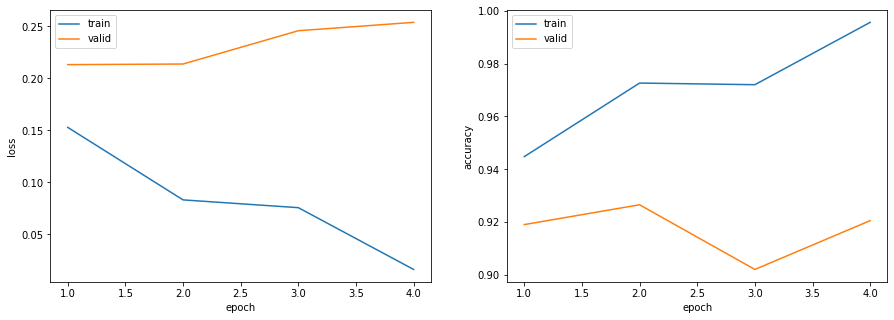

In [ ]:
# ログの可視化
x_axis = [x for x in range(1, len(log['train']) + 1)]
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(x_axis, np.array(log['train']).T[0], label='train')
ax[0].plot(x_axis, np.array(log['valid']).T[0], label='valid')
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('loss')
ax[0].legend()
ax[1].plot(x_axis, np.array(log['train']).T[1], label='train')
ax[1].plot(x_axis, np.array(log['valid']).T[1], label='valid')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('accuracy')
ax[1].legend()
plt.show()

In [ ]:
# 正解率の算出
dataloader_train = DataLoader(dataset_train, batch_size=1, shuffle=False)
dataloader_valid = DataLoader(dataset_valid, batch_size=1, shuffle=False)
dataloader_test = DataLoader(dataset_test, batch_size=1, shuffle=False)

print(
    f'正解率（学習データ）：{calculate_loss_and_accuracy(model, dataloader_train, device, 1)[1]:.3f}')
print(
    f'正解率（検証データ）：{calculate_loss_and_accuracy(model, dataloader_valid, device, 1)[1]:.3f}')
print(
    f'正解率（評価データ）：{calculate_loss_and_accuracy(model, dataloader_test, device, 1)[1]:.3f}')

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


正解率（学習データ）：0.996
正解率（検証データ）：0.920
正解率（評価データ）：0.925


In [ ]:
dataloader_compe = DataLoader(dataset_compe, batch_size=1, shuffle=False)

pred = []
with torch.no_grad():
  for data in dataloader_compe:
    # デバイスの指定
    ids = data['ids'].to(device)
    mask = data['mask'].to(device)

    # 順伝播
    outputs = model(ids, mask, 1)

    # 正解率計算
    # バッチサイズの長さの予測ラベル配列
    pred_label = torch.argmax(outputs, dim=-1).cpu().numpy()
    pred.append(pred_label[0])

  csv_data = pd.DataFrame(data=pred, columns=["label"])
  csv_data.reset_index(inplace=True)
  csv_data = csv_data.rename(columns={'index': 'ID'})
  # submission.csvを最大2つまで馬場宛に提出してください．良い方の結果を最終スコアとします．
  csv_data.to_csv(submission_path, index=False)